# Let's see how GPT models work, by looking at GPT-2
- https://huggingface.co/gpt2
- Smallest version, with 124M parameters
- Released in 2019, https://openai.com/research/better-language-models

## First, let's initialize GPT-2 models and tokenizers

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextStreamer, GenerationConfig
import torch
import torch.nn.functional as F

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", device='cuda')
model = GPT2LMHeadModel.from_pretrained("gpt2", device='cuda')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Let's see how our GPT-2 tokenizer tokenizes.

In [ ]:
# Encode a text prompt
input_text = "I am hungry. Let's go to McDonald's and eat some"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
input_ids

tensor([[   40,   716, 14720,    13,  3914,   338,   467,   284, 14115,   338,
           290,  4483,   617,  9015]])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens

['I',
 'Ġam',
 'Ġhungry',
 '.',
 'ĠLet',
 "'s",
 'Ġgo',
 'Ġto',
 'ĠMcDonald',
 "'s",
 'Ġand',
 'Ġeat',
 'Ġsome',
 'Ġchicken']

## Now let's throw the phrase in and let GPT-2 calculate the distribution for the next token.

In [ ]:
# Forward pass through the model
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits[:, -1, :]


In [ ]:
# Apply temperature scaling
temperature = 0.5
scaled_logits = logits / temperature

# Apply softmax to get probabilities
probabilities = F.softmax(scaled_logits, dim=-1)

In [ ]:
# Sort probabilities to get top values and indices
top_k = 5  # Number of top tokens you want to consider
top_values, top_indices = torch.topk(probabilities, top_k)

# Map top indices to tokens and print them alongside their probabilities
for value, index in zip(top_values[0], top_indices[0]):
    token = tokenizer.decode([index.item()])
    print(f"Token: {token}, Index: {index}, Probability: {value.item()}")


Token: .", Index: 526, Probability: 0.3581917881965637
Token: ., Index: 13, Probability: 0.3503537178039551
Token: !", Index: 2474, Probability: 0.07218604534864426
Token:  and, Index: 290, Probability: 0.06958077102899551
Token:  wings, Index: 12098, Probability: 0.06187603250145912


## Notice how different temperature settings change the distribution.

The lower the temperature is, the more deterministic the output is.

In [ ]:
# Apply temperature scaling
temperature = 0.1
scaled_logits = logits / temperature

# Apply softmax to get probabilities
probabilities = F.softmax(scaled_logits, dim=-1)

# Sort probabilities to get top values and indices
top_k = 5  # Number of top tokens you want to consider
top_values, top_indices = torch.topk(probabilities, top_k)

# Map top indices to tokens and print them alongside their probabilities
for value, index in zip(top_values[0], top_indices[0]):
    token = tokenizer.decode([index.item()])
    print(f"Token: {token}, Index: {index}, Probability: {value.item()}")


Token:  chicken, Index: 9015, Probability: 0.7102358937263489
Token:  food, Index: 2057, Probability: 0.2888943552970886
Token:  of, Index: 286, Probability: 0.00043148142867721617
Token:  fries, Index: 31757, Probability: 0.00042086924077011645
Token:  McDonald, Index: 14115, Probability: 6.427331754821353e-06


In [ ]:
# Apply temperature scaling
temperature = 1
scaled_logits = logits / temperature

# Apply softmax to get probabilities
probabilities = F.softmax(scaled_logits, dim=-1)

# Sort probabilities to get top values and indices
top_k = 5  # Number of top tokens you want to consider
top_values, top_indices = torch.topk(probabilities, top_k)

# Map top indices to tokens and print them alongside their probabilities
for value, index in zip(top_values[0], top_indices[0]):
    token = tokenizer.decode([index.item()])
    print(f"Token: {token}, Index: {index}, Probability: {value.item()}")


Token:  chicken, Index: 9015, Probability: 0.07896645367145538
Token:  food, Index: 2057, Probability: 0.07217292487621307
Token:  of, Index: 286, Probability: 0.03765279799699783
Token:  fries, Index: 31757, Probability: 0.03755897656083107
Token:  McDonald, Index: 14115, Probability: 0.02472309209406376


## Let's look at the attention weights.

On which tokens do the model focus on, when it generates 'chicken'?

In [ ]:
# Encode a text prompt
input_text = "I am hungry. Let's go to McDonald's and eat some chicken"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

In [ ]:
# Set the model to return attention weights
model.config.output_attentions = True

# Get the model outputs
outputs = model(input_ids)

# Extract the attention weights
attention_weights = outputs.attentions

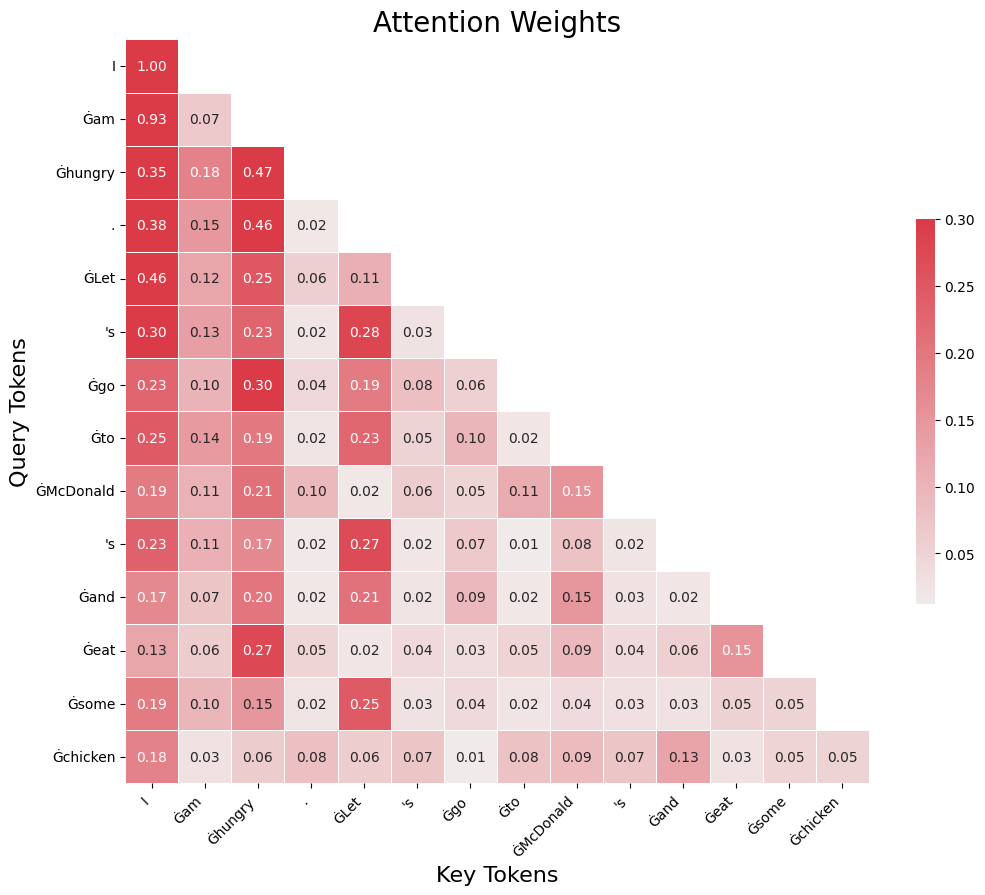

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'attention_weights' is obtained as shown previously
# Choose which layer and head to visualize
layer = 0
head = 0

# Get the attention weights from the chosen layer and head
attention_matrix = attention_weights[layer][0, head].detach().numpy()

# Define a threshold to only annotate significant attention weights
threshold = 0.001

# Create a mask to only annotate significant attention weights
mask = attention_matrix < threshold

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(attention_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
            xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]),
            yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]))

# Ensure the axis ticks are readable
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add labels and title
plt.title('Attention Weights', fontsize=20)
plt.xlabel('Key Tokens', fontsize=16)
plt.ylabel('Query Tokens', fontsize=16)

plt.show()


## Lastly, let GPT-2 complete the sentence.

In [ ]:
inputs = tokenizer("I am hungry. Let's go to McDonald's and eat some", return_tensors="pt", return_attention_mask=True)

generation_config = GenerationConfig(
    max_length=150, temperature=0.01, top_p=0.95, repetition_penalty=1.1,
    do_sample=True, use_cache=True,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    transformers_version="4.33.1"
    )

outputs = model.generate(**inputs, generation_config=generation_config)
text = tokenizer.batch_decode(outputs)[0]
print(text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am hungry. Let's go to McDonald's and eat some chicken."
"What?" I asked, looking at the menu on my phone as if it were a question that had been raised in front of me for years now by people who have never heard about this restaurant before or even know what they are talking here about. "Why don't you just take your kids out there with us? We're going home tonight!" The waitress said excitedly while she was eating her lunch; we all knew exactly how much better off our children would be when their parents got back from school today! It wasn' so bad because everyone else is still working hard but not really doing anything except watching TV (which isn`t very good either). She then


# Now let's try a better model, Qwen2.5-1.5B-Instruct.

- Released on Sep 2024 by Qwen team in Alibaba Cloud
- 1.5 Billion parameters, around 3 GB
- Also the model weights are publicly accessible.
- https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct
- https://github.com/QwenLM/Qwen2.5
- It is an instruction-tuned model, which tailors an LLM to Q&A tasks, behave more like a chatbot. (https://www.ibm.com/topics/instruction-tuning)
- Also preference-tuned with RLHF (Reinforcement Learning with Human Feedback, https://www.assemblyai.com/blog/how-rlhf-preference-model-tuning-works-and-how-things-may-go-wrong/).
- Of course, there are much bigger and better models with publicly accessible model weights. However, these models are too large to fit in Free Google Colab environment without some smart tricks like quantization.

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer, GenerationConfig
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")

# Move the model to the desired device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get the appropriate device
model.to(device)  # Move the model to the device

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

In [ ]:
# Encode a text prompt
input_text = "I am hungry. Let's go to McDonald's and eat some"
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device) # Move input_ids to the device

In [ ]:
# Forward pass through the model
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits[:, -1, :]

# Apply temperature scaling
temperature = 0.5
scaled_logits = logits / temperature

# Apply softmax to get probabilities
probabilities = F.softmax(scaled_logits, dim=-1)

In [ ]:
# Sort probabilities to get top values and indices
top_k = 5  # Number of top tokens you want to consider
top_values, top_indices = torch.topk(probabilities, top_k)

# Map top indices to tokens and print them alongside their probabilities
for value, index in zip(top_values[0], top_indices[0]):
    token = tokenizer.decode([index.item()])
    print(f"Token: {token}, Index: {index}, Probability: {value.item()}")


Token:  hamburg, Index: 56847, Probability: 0.818225622177124
Token:  burgers, Index: 62352, Probability: 0.08032813668251038
Token:  food, Index: 3607, Probability: 0.0463644340634346
Token:  fast, Index: 4937, Probability: 0.020614787936210632
Token:  chicken, Index: 16158, Probability: 0.010843025520443916


## Along with model capabilities, the context size also got bigger over time.
- This means we can cram in more information in our prompts about how we want the models to behave, previous chat logs, long questions, and so on. It follows the instruction we give it quite well.
- Yeah, basically what we all do with ChatGPT nowadays.

In [ ]:
?GenerationConfig

In [ ]:
sys_prompt = "First choose the right option, and then provide your explanation."

prompt = """What is McDonald's famous burger called?
A. Whopper
B. Big Mac
C. Baconator
D. Double-double"""

input_text = f"""<|im_start|>system
{sys_prompt}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant"""

generation_config = GenerationConfig(
    max_length=1024, temperature=0.01, top_p=0.95, repetition_penalty=1.1,
    do_sample=True, use_cache=True, max_new_tokens=100,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    transformers_version="4.33.1"
    )

streamer = TextStreamer(tokenizer, skip_prompt=False)
inputs = tokenizer(input_text, return_tensors="pt", return_attention_mask=False).to('cuda')
outputs = model.generate(**inputs, streamer=streamer, generation_config=generation_config)

<|im_start|>system
First choose the right option, and then provide your explanation.<|im_end|>
<|im_start|>user
What is McDonald's famous burger called?
A. Whopper
B. Big Mac
C. Baconator
D. Double-double<|im_end|>
<|im_start|>assistant
The correct answer is B. Big Mac.

Explanation:
- The "Big Mac" is a popular fast food hamburger sandwich that originated in 1967 at the White Castle restaurant chain.
- It consists of two all-beef patties, special sauce, lettuce, cheese, pickles, and American cheese on a sesame seed bun.
- The name "Big Mac" was chosen because it was intended to be twice as big as the original White Castle hamburgers.
- While other options


In [ ]:
text = tokenizer.batch_decode(outputs)[0]
print(text)

<|im_start|>system
First choose the right option, and then provide your explanation.<|im_end|>
<|im_start|>user
What is McDonald's famous burger called?
A. Whopper
B. Big Mac
C. Baconator
D. Double-double<|im_end|>
<|im_start|>assistant
The correct answer is B. Big Mac.

Explanation:
- The "Big Mac" is a popular fast food hamburger sandwich that originated in 1967 at the White Castle restaurant chain.
- It consists of two all-beef patties, special sauce, lettuce, cheese, pickles, and American cheese on a sesame seed bun.
- The name "Big Mac" was chosen because it was intended to be twice as big as the original White Castle hamburgers.
- While other options


[link text](https://)# Main takeaways:
- While ChatGPT may seem miraculous, it is not magic nor did it emerge from a vacuum.
- The open-source community has contributed significant efforts to the development of LLMs.
- Although open-weight models do not match the performance of GPT-4-class models, they are smaller, more efficient, and open.
- These open-weight models allow researchers to look deeper into the inner workings of large language models (LLMs).



# On Your Own
- Try to Prompt-Engineer the task you want to try out!